<a href="https://colab.research.google.com/github/KondamPravalikaReddy/AirAware-Smart-Air-Quality-Prediction/blob/main/Seaborn_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Upload kaggle.json (from your Kaggle account → API → Create New Token)
from google.colab import files
files.upload()   # Upload kaggle.json here

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pravalikareddi","key":"cc23ca85e0877e600aaa326978d10bad"}'}

In [3]:
# Move kaggle.json to correct path
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download Dataset
!kaggle datasets download -d fedesoriano/air-quality-data-set --unzip

#  Load Dataset
import pandas as pd

df = pd.read_csv("AirQuality.csv", sep=';', low_memory=False)
print("Original Data:\n")
print(df.head())

Dataset URL: https://www.kaggle.com/datasets/fedesoriano/air-quality-data-set
License(s): copyright-authors
  0% 0.00/248k [00:00<?, ?B/s]
100% 248k/248k [00:00<00:00, 633MB/s]
Original Data:

         Date      Time CO(GT)  PT08.S1(CO)  NMHC(GT) C6H6(GT)  PT08.S2(NMHC)  \
0  10/03/2004  18.00.00    2,6       1360.0     150.0     11,9         1046.0   
1  10/03/2004  19.00.00      2       1292.0     112.0      9,4          955.0   
2  10/03/2004  20.00.00    2,2       1402.0      88.0      9,0          939.0   
3  10/03/2004  21.00.00    2,2       1376.0      80.0      9,2          948.0   
4  10/03/2004  22.00.00    1,6       1272.0      51.0      6,5          836.0   

   NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T    RH  \
0    166.0        1056.0    113.0        1692.0       1268.0  13,6  48,9   
1    103.0        1174.0     92.0        1559.0        972.0  13,3  47,7   
2    131.0        1140.0    114.0        1555.0       1074.0  11,9  54,0   
3    172.0      

In [17]:
# Common imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource
from bokeh.layouts import gridplot

# Display plots inline
output_notebook()

# Load dataset
# The file is semicolon delimited
df = pd.read_csv("AirQuality.csv", sep=';', low_memory=False)

# Basic cleaning
# Remove the extra semicolon column at the end
df = df.iloc[:, :-1]
df = df.dropna(how='all')

# Rename columns to remove spaces and special characters, making them lowercase
df.columns = df.columns.str.replace('[^A-Za-z0-9_]+', '', regex=True).str.lower()

# Rename date and time columns to standard names
df = df.rename(columns={'date': 'date', 'time': 'time'})

# Combine date and time and convert to datetime
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'], format='%d/%m/%Y %H.%M.%S', errors='coerce')

# Drop original date and time columns
df = df.drop(['date', 'time'], axis=1)

# Convert pollutant columns to numeric, coercing errors
# Identify pollutant columns (columns that are not datetime)
# Include 'cogt' specifically to ensure it's handled
pollutant_cols = [col for col in df.columns if col not in ['datetime', 'year', 'month', 'day_of_week', 'daytype']]

for col in pollutant_cols:
    # Replace comma with dot for decimal separation before converting to numeric
    if df[col].dtype == 'object':
      df[col] = df[col].str.replace(',', '.', regex=False)
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows where datetime is not valid
df = df.dropna(subset=['datetime'])

# Create Year and Month columns from datetime
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month_name()
df['day_of_week'] = df['datetime'].dt.dayofweek
df['DayType'] = df['day_of_week'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

# Define pollutant columns based on the dataset
pollutant_cols_present = [col for col in ['cogt', 'pt08s1_co', 'nmhc_gt', 'c6h6_gt', 'pt08s2_nmhc', 'nox_gt', 'pt08s3_nox', 'no2_gt', 'pt08s4_no2', 'pt08s5_o3', 't', 'rh', 'ah'] if col in df.columns]

# Drop rows with missing values in pollutant columns that are critical for analysis
df = df.dropna(subset=pollutant_cols_present)

# There is no 'sitename' or 'Station' column in this dataset, so the city_col variable is not applicable
# city_col = None

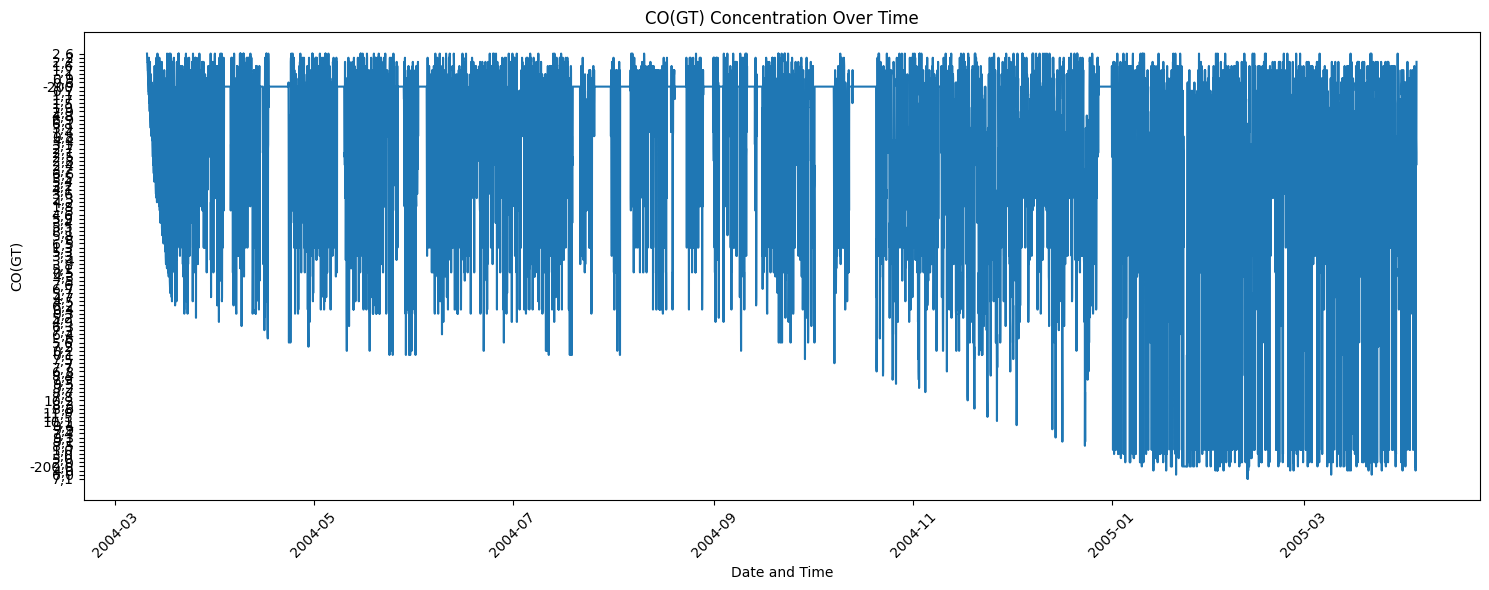

In [11]:
# Time series plot for CO(GT)
plt.figure(figsize=(15, 6))
sns.lineplot(data=df, x='datetime', y='cogt')
plt.title('CO(GT) Concentration Over Time')
plt.xlabel('Date and Time')
plt.ylabel('CO(GT)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

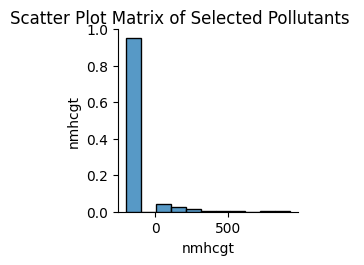

In [15]:
# Scatter plot matrix of pollutants

pollutant_cols_for_scatter_matrix = [col for col in ['cogt', 'pt08s1_co', 'nmhcgt', 'c6h6gt', 'pt08s2_nmhc', 'nox_gt', 'pt08s3_nox', 'no2_gt', 'pt08s4_no2', 'pt08s5_o3', 't', 'rh', 'ah'] if col in df.columns]

if all(col in df.columns for col in pollutant_cols_for_scatter_matrix):
    sns.pairplot(df[pollutant_cols_for_scatter_matrix].sample(min(1000, len(df)))) # Sample for performance
    plt.suptitle('Scatter Plot Matrix of Selected Pollutants ', y=1.02)
    plt.show()
else:
    print("Skipping Scatter Plot Matrix due to missing columns.")

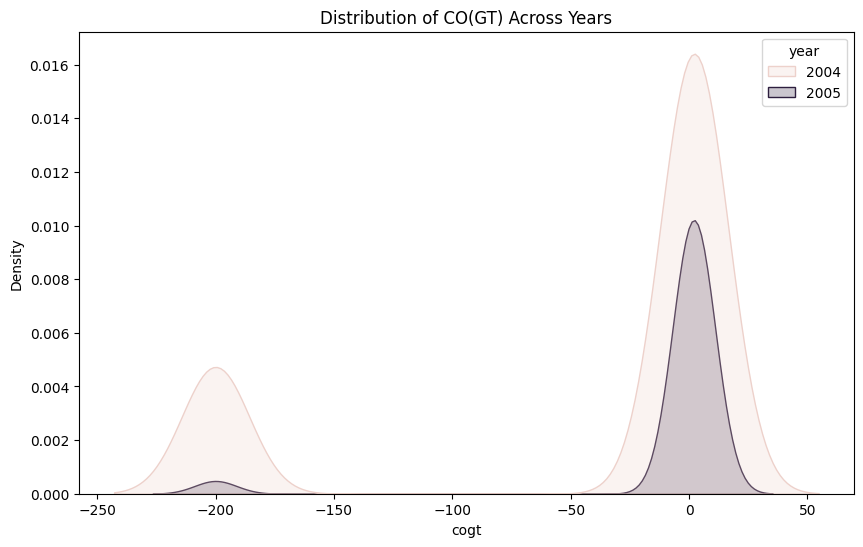

In [18]:
# Ridge plot (KDE) of pollutant by year - Using 'cogt' as an example pollutant
plt.figure(figsize=(10,6))
sns.kdeplot(data=df, x="cogt", hue="year", fill=True) # Use 'cogt' column
plt.title('Distribution of CO(GT) Across Years') # Update title
plt.show()
print("\n" * 2)

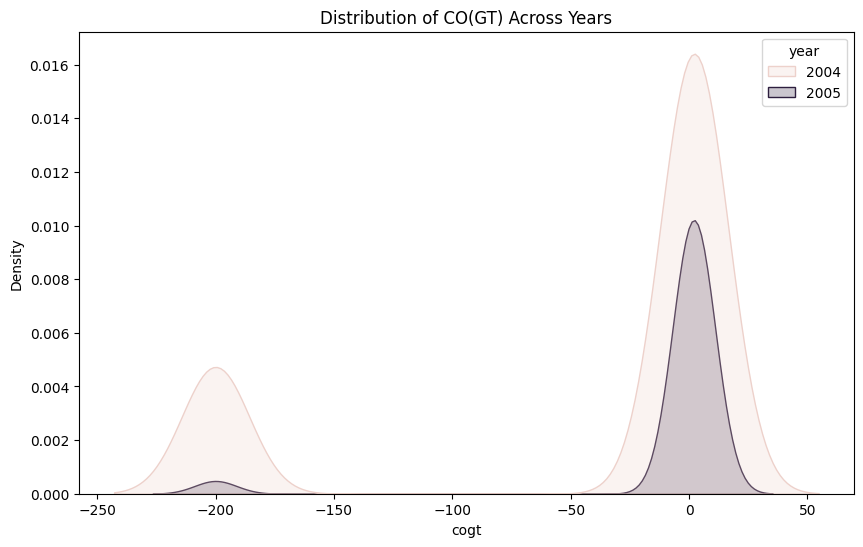

In [19]:
# Ridge plot (KDE) of pollutant by year - Using 'cogt' as an example pollutant
plt.figure(figsize=(10,6))
sns.kdeplot(data=df, x="cogt", hue="year", fill=True) # Use 'cogt' column
plt.title('Distribution of CO(GT) Across Years') # Update title
plt.show()
print("\n" * 2)

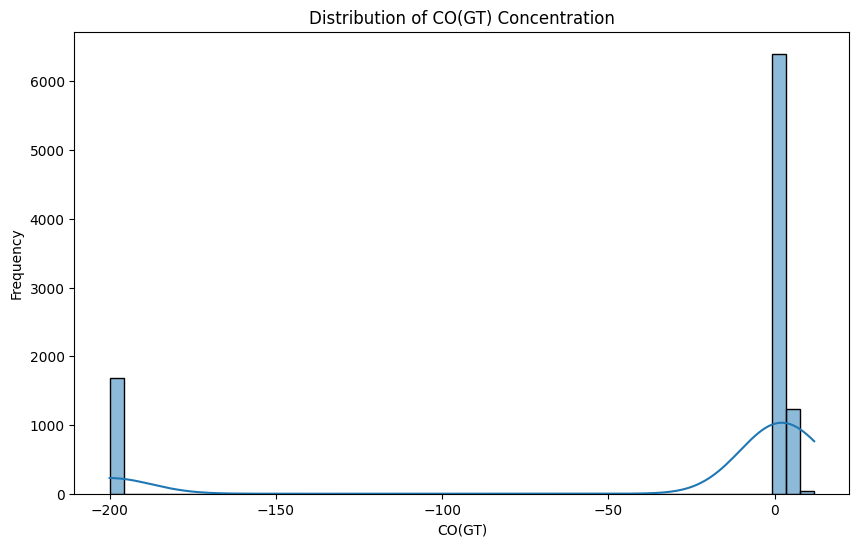

In [21]:
# Histogram of CO(GT) concentration
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='cogt', kde=True, bins=50) # Use histplot for a histogram with KDE
plt.title('Distribution of CO(GT) Concentration')
plt.xlabel('CO(GT)')
plt.ylabel('Frequency')
plt.show()

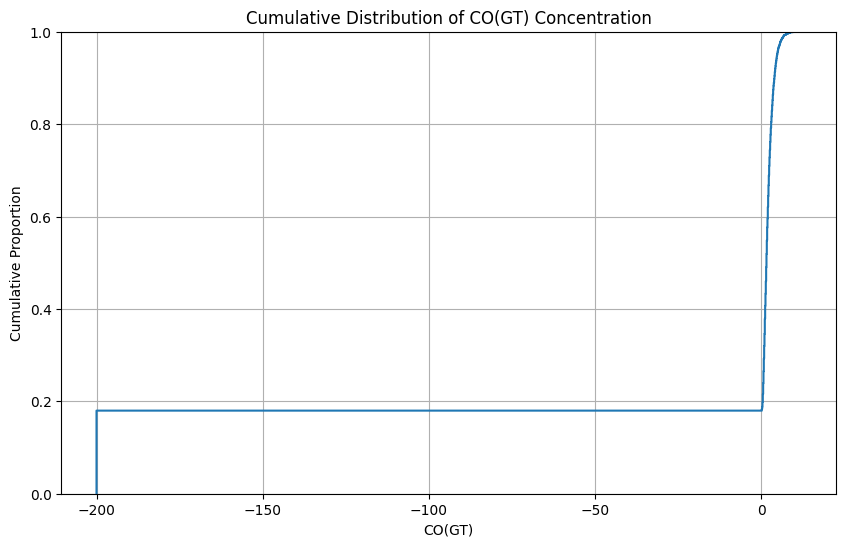

In [22]:
# Cumulative Distribution Plot for CO(GT)
plt.figure(figsize=(10, 6))
sns.ecdfplot(data=df, x='cogt')
plt.title('Cumulative Distribution of CO(GT) Concentration')
plt.xlabel('CO(GT)')
plt.ylabel('Cumulative Proportion')
plt.grid(True)
plt.show()

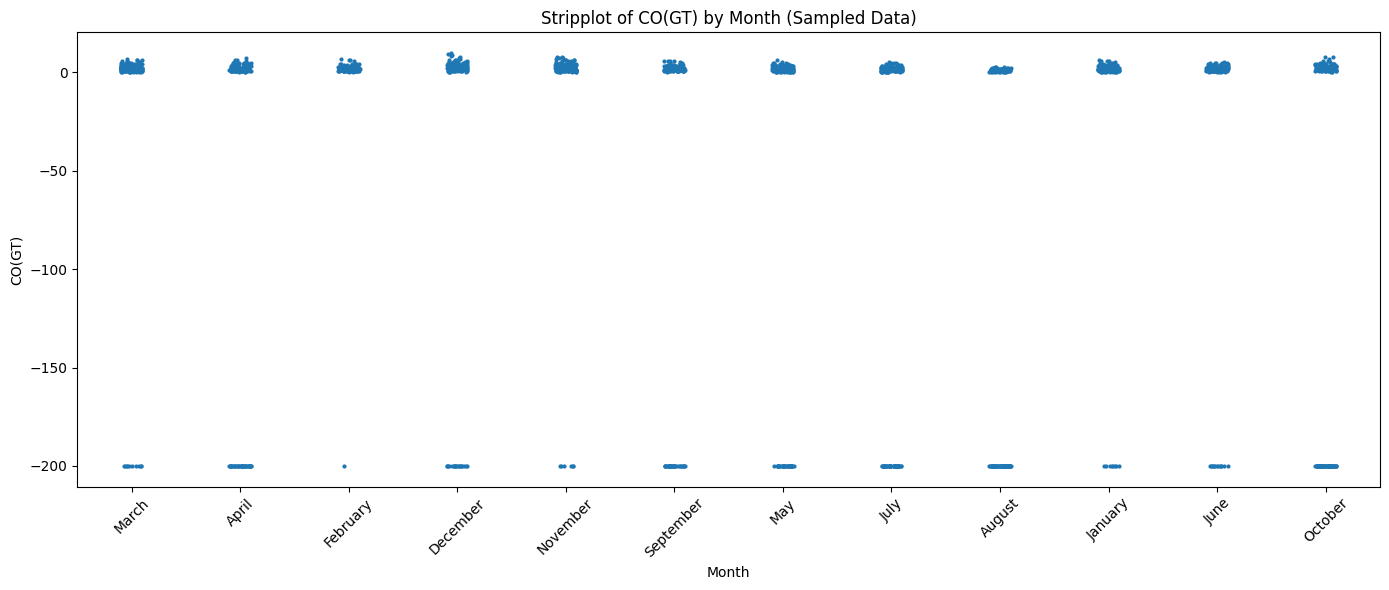

In [26]:
# Stripplot of CO(GT) by month
plt.figure(figsize=(14, 6))
sns.stripplot(data=df.sample(min(2000, len(df))), x='month', y='cogt', jitter=True, size=3) # Sample for performance, use jitter to avoid overplotting
plt.title('Stripplot of CO(GT) by Month (Sampled Data)')
plt.xlabel('Month')
plt.ylabel('CO(GT)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

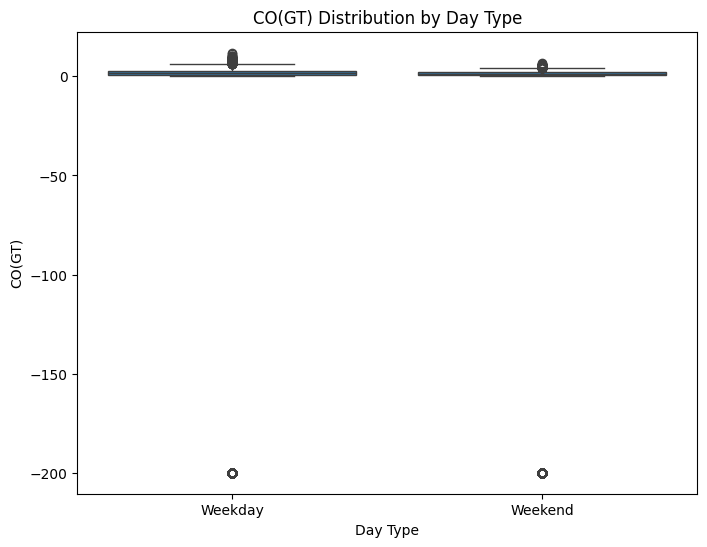

In [27]:
# Boxplot of CO(GT) by DayType
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='DayType', y='cogt')
plt.title('CO(GT) Distribution by Day Type')
plt.xlabel('Day Type')
plt.ylabel('CO(GT)')
plt.show()